In [589]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

In [496]:
def choose(pi):
    """Return random index of pi according to probability within"""
    return np.searchsorted(pi.cumsum(), np.random.rand())

import scipy.signal as ss
def moving_average(a, m):
    return ss.convolve(a, np.ones(m), mode = 'same') / m

# Kinetic Monte Carlo

Algorithm description [[1](https://en.wikipedia.org/wiki/Kinetic_Monte_Carlo#Rejection-free_KMC)]
1. define discrete states $i$ of your system
2. define transition rates between them $k_{ij}$
3. for a given state $i$ pick a state $j$ with probablity $p_{i\to j} = \frac{k_{ij}}{\sum_{j'} k_{ij'}}$, i.e. proportional to their rate
4. sample step time $\Delta t$ from an exponential distribution with mean $\bar T_i^{-1} = \sum_{j} k_{ij}$

## Deterministic Walk
Let's do the most easiest thing first, just to build the algorithm. We are moving in one direction with a fixed velocity.
Assuming we walk on a ladder, then we are going from $x_i$ to $x_{i+1}$ with a rate equal to our velocity

In [11]:
v = 0.5 # steps per second or whatever

For simplicity let's assume we have

In [8]:
n = 20

steps on the ladder. We can then write down all the transition rates in a simple matrix

In [45]:
k = np.zeros( (n, n) )
for i in range(n - 1):
    k[i, i + 1] = v

Let's also assume the ladder wraps around

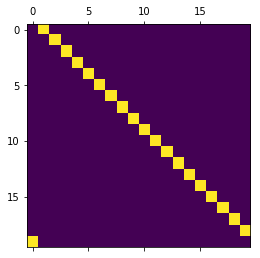

In [46]:
k[-1, 0] = v

plt.matshow(k)

We start all the way to the left

In [47]:
t = 0
i = 0
# array of all jump probabilities as defined above
pij = k[i, :] / k[i, :].sum()
Ti = 1 / k[i, :].sum()

I already defined a function `choose()` that picks an index given an array of probabilities.

In [22]:
choose(pij)

1

Obviously there's only one possible jump here, but you get the idea.

To update the time we need to sample the exponential function, which we can do with `numpy.random`.

In [69]:
Δt = np.random.exponential(Ti)
Δt

0.18776944221416442

Putting all of this together we can let this simulation run for some steps, like this

In [519]:
i = 0
t = 0
states = []
times  = []
for _ in range(15):
    states.append(i)
    times.append(t)
    pij = k[i, :] / k[i, :].sum()
    Ti = 1/ k[i, :].sum()
    i = choose(pij)
    t += np.random.exponential(Ti)
    
states = np.array(states)
times = np.array(times)

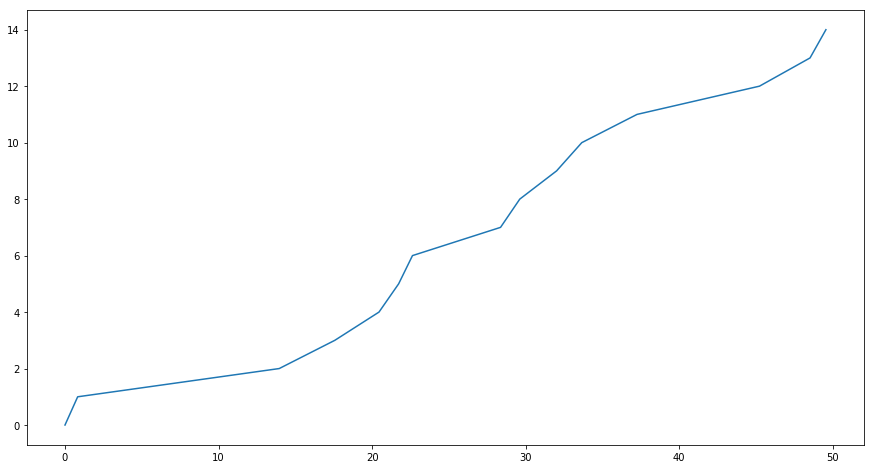

In [520]:
plt.plot(times, states)

## Biased Random Walk
Now for something not quite as predictable. Here at every step we jump forward with

In [130]:
k_plus = 1.2

and backwards with

In [141]:
k_minus = .5

But first let's abstract our approach a little bit by defining a function that does most of the simulation for us.

In [129]:
def kmc_matrix(rates, steps, initial = 0):
    i = initialjj
    t = 0
    times = np.zeros( steps )
    states = np.zeros( steps )
    for m in range(steps):
        times[m] = t
        states[m] = i
        
        pij = rates[i, :] / rates[i, :].sum()
        Ti = 1 / rates[i, :].sum()
        i = choose(pij)
        t += np.random.exponential(Ti)
    
    return times, states

This does the same as our loop above, but for any kind of rate matrix. So we define the one for the random walk

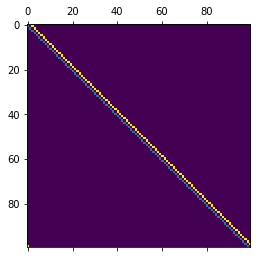

In [144]:
n = 100
k_rw = np.zeros( (n, n) )
for m in range(1, n - 1):
    k_rw[m, m + 1] = k_plus
    k_rw[m, m - 1] = k_minus

k_rw[0, 1] = k_plus
k_rw[0, n - 1] = k_minus
k_rw[n - 1, 0] = k_plus
k_rw[n - 1, n - 2] = k_minus
plt.matshow(k_rw)

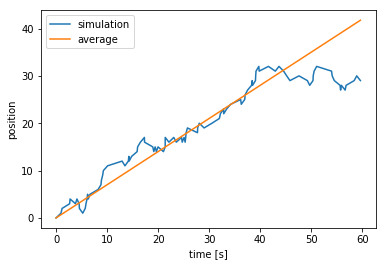

In [157]:
t, s = kmc_matrix(k_rw, 100)
plt.plot(t, s, label = 'simulation')
plt.plot(t, t * (k_plus - k_minus), label = 'average')
plt.xlabel('time [s]')
plt.ylabel('position')
plt.legend()

On average we would expect a velocity of $v = k_+ - k_-$, which is also plotted above.

## Slow and Fast Diffusion
As a slightly more complicated and contrived example, consider a protein that tries to find a specific site along a DNA molecule

Until now we got away with a finite 1D state space, for more complicated examples, we want a state representation that allows for multiple variables (e.g. concentrations of multiple chemical species). Matrices for such system would need to be multidimensional and get large very fast. So instead of matrices, we can use a function that takes a state and returns possible jumps to represent our system.

In [158]:
def random_walk_jumps(pos, time):
    k_plus = 1
    k_minus = 1
    return [
        (pos + 1, k_plus),
        (pos - 1, k_minus)
    ]

In [234]:
def kmc(get_jumps, steps, initial = 0):
    i = initial
    t = 0
    times = [t]
    states = [i]
    for m in range(steps):
        
        new_states, rates = zip(*get_jumps(i, t))
        rates = np.array(rates)
        
        s = rates.sum()
        if s == 0:
            print("get_jumps returned only zero jump rates on state {}".format(i))
            break
        
        pij = rates / rates.sum()
        Ti = 1 / rates.sum()
        i = new_states[choose(pij)]
        t += np.random.exponential(Ti)
        
        times.append(t)
        states.append(i)
    
    return np.array(times), states

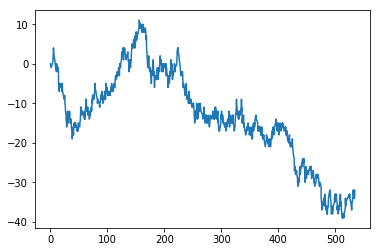

In [170]:
plt.plot(*kmc(random_walk_jumps, 1000, 0))

Using this formulation we can also easily write down the random walk in 2D

In [227]:
def random_walk_2d_jumps(pos, time):
    x = pos[0]
    y = pos[1]
    
    kx = 3
    ky = .5
    
    return [
        ([x + 1, y + 0], kx),
        ([x - 1, y + 0], kx),
        ([x + 0, y + 1], ky),
        ([x + 0, y - 1], ky)
    ]

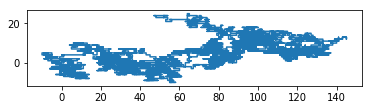

In [228]:
t, pos = kmc(random_walk_2d_jumps, 10000, (0, 0))
plt.plot(*zip(*pos))
plt.gca().set_aspect(1)

## Chemical Reactions

Or a enzymatic reaction that catalyses its own inhibitor.

A + E $\stackrel{k}{\leftrightarrow}$ E + B

B + E $\stackrel{q}{\leftrightarrow}$ E'

In [224]:
def enzyme_jumps(state, time):
    a = state[0]
    b = state[1]
    e = state[2]
    i = state[3]
    
    # first reaction in both directions
    k_forw =  1
    k_back = .1 # back reaction is much slower
    
    q_forw = 1
    q_back = 0.1
    
    return [
        ((a - 1, b + 1, e    , i    ), k_forw * a * e),
        ((a + 1, b - 1, e    , i    ), k_back * b * e),
        ((a    , b - 1, e - 1, i + 1), q_forw * b * e),
        ((a    , b + 1, e + 1, i - 1), q_back * i),
    ]

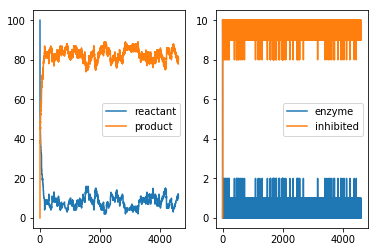

In [225]:
times, states = kmc(enzyme_jumps, steps = 10000, initial = (100, 0, 10, 0))
a, b, e, i = zip(*states)
plt.subplot(121)
plt.plot(times, a, label = 'reactant')
plt.plot(times, b, label = 'product')
plt.legend()
plt.subplot(122)
plt.plot(times, e, label = 'enzyme')
plt.plot(times, i, label = 'inhibited')
plt.legend()

## Brusselator [[2](https://en.wikipedia.org/wiki/Brusselator)]

${\displaystyle A\rightarrow X}$

$2X+Y\rightarrow 3X$

$B+X\rightarrow Y+D$

$X\rightarrow E$

where $A$ and $B$ are assumed constant. Also $D$ and $E$ only ever turns up as a products, so let's not model those as well. We have to keep the reaction that reduces $X$ to $E$, though

In [328]:
def brusselator_jumps(state, time):
    x, y = state
    
    a = 1
    b = 3
    
    Δc = 1e-2
    return [
        ((x + 1 * Δc, y         ), a),
        ((x + 1 * Δc, y - 1 * Δc), x * x * y),
        ((x - 1 * Δc, y + 1 * Δc), b * x),
        ((x - 1 * Δc, y         ), x)
    ]

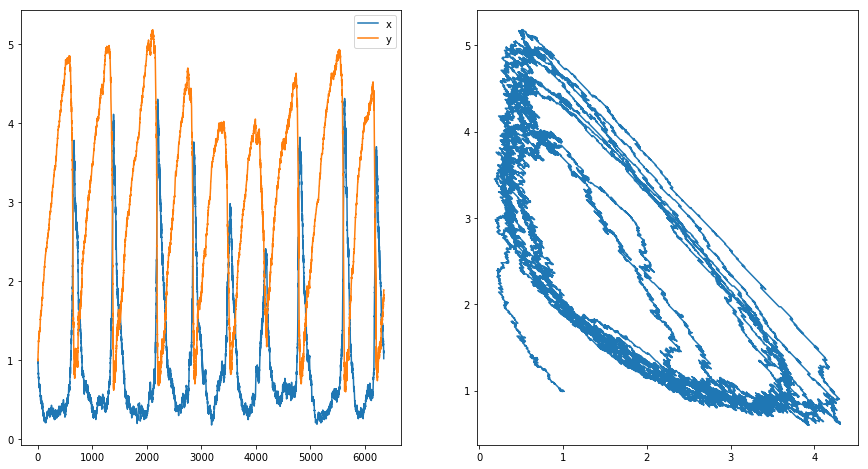

In [331]:
times, states = kmc(brusselator_jumps, steps = 50000, initial = (1, 1))
x, y = zip(*states)
plt.subplot(121)
plt.plot(times, x, label = 'x')
plt.plot(times, y, label = 'y')
plt.legend()
plt.subplot(122)
plt.plot(x, y)

## Molecular Motors

### Model 1


In [596]:
def motor1(ΔF = 1, fd = -1, k = 1, flux = (1, 1)):
    # ΔF is the free reaction energy of ATP -> ADP + P
    # fd work performed by the motor every step
    # both in units of kB T
    
    # number of molecules of ATP, ADP, P flush in or out of the system
    flux_in, flux_out = flux
    
    reaction_forw = k
    reaction_back = reaction_forw * np.exp(-ΔF + fd)
    print('forward', reaction_forw)
    print('backward', reaction_back)
    
    def jumps(state, time):
        atp, adp, p, m = state
        return [
            ( (atp + 1, adp    , p    , m    ), flux_in ),
            ( (atp    , adp - 1, p    , m    ), flux_out * (adp > 0)),
            ( (atp    , adp    , p - 1, m    ), flux_out * (p > 0) ),
            ( (atp - 1, adp + 1, p + 1, m + 1), atp * reaction_forw ),
            # ( (atp + 1, adp - 1, p - 1, m - 1), atp * reaction_back * (adp > 0) * (p > 0) ),
            ( (atp + 1, adp - 1, p - 1, m - 1), adp * p / atp * reaction_back )
        ]
    
    return jumps

forward 1
backward 0.1353352832366127


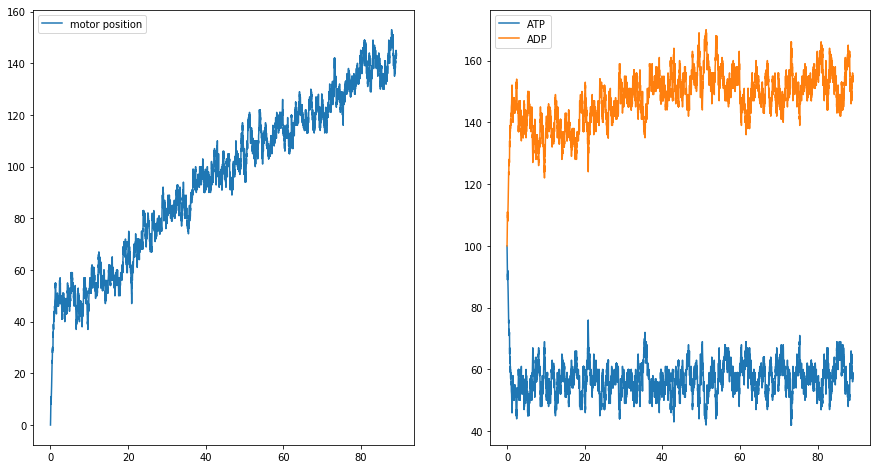

In [602]:
times, states = kmc(motor1(ΔF = 3, fd = 1, flux = (1, 1)), 10000, initial = (100, 100, 100, 0))
atp, adp, p, m = zip(*states)
plt.subplot(121)
plt.plot(times, m, label = 'motor position')
plt.legend()
plt.subplot(122)
plt.plot(times, atp, label = 'ATP')
plt.plot(times, adp, label = 'ADP')
plt.legend()

2522.4068716667757


(array([ 422., 8064., 1107.,  174.,  133.,    0.,    0.,    0.,    0.,
         100.]),
 array([-30265.67498654, -12436.13313596,   5393.40871462,  23222.9505652 ,
         41052.49241578,  58882.03426637,  76711.57611695,  94541.11796753,
        112370.65981811, 130200.20166869, 148029.74351927]),
 <a list of 10 Patch objects>)

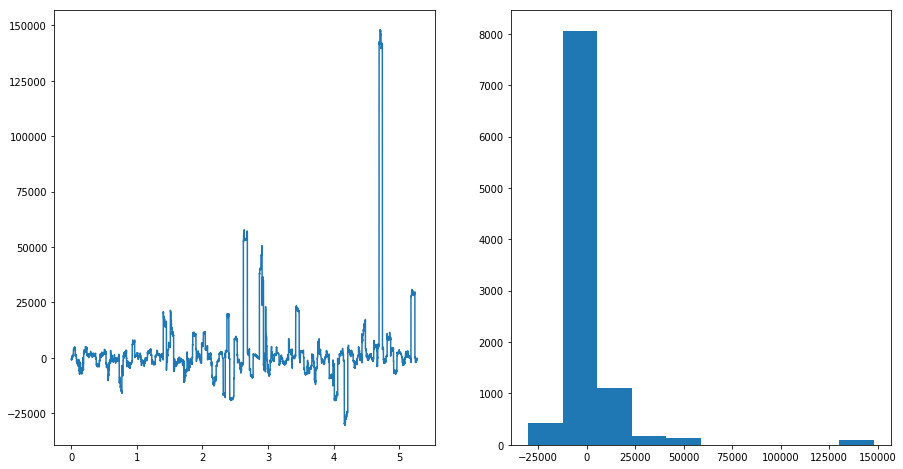

In [551]:
power_out = moving_average(np.diff(m) / np.diff(times), 100)
print(power_out.mean())
plt.subplot(121)
plt.plot(times[1:], power_out)
plt.subplot(122)
plt.hist(power_out)

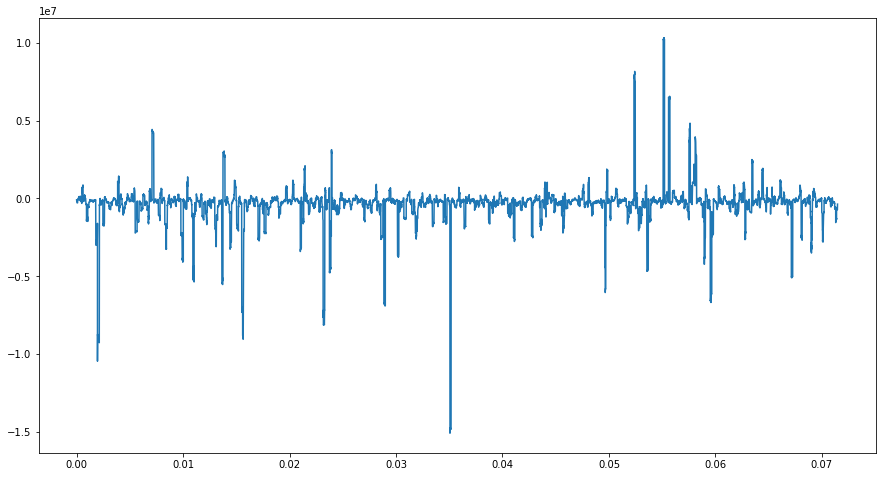

In [511]:
power_in = moving_average(np.diff(atp) / np.diff(times), 20)
plt.plot(times[1:], power_in)

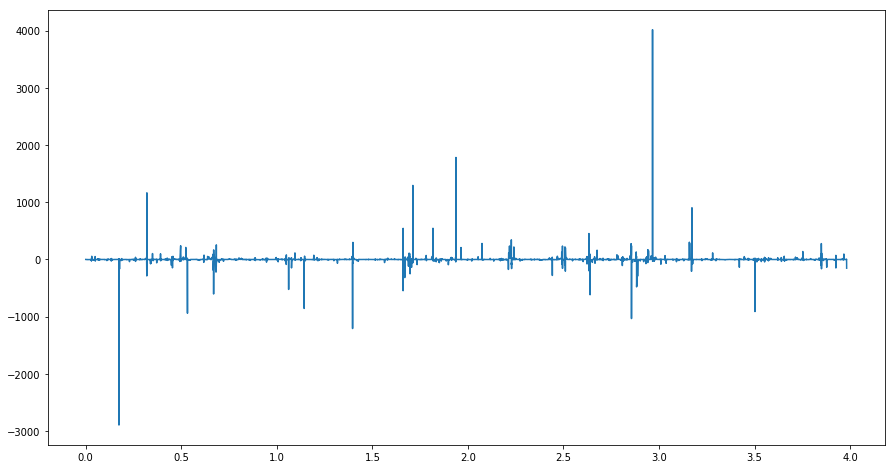

In [508]:
plt.plot(times[1:], power_out / power_in)

### Motor 2

In [581]:
def motor2(influx = 0, prod = .1, ΔF = 1, fd = .5, k = 1):
    # ΔF is the free reaction energy of ATP -> ADP + P
    # fd work performed by the motor every step
    # both in units of kB T
    
    reaction_forw = k
    reaction_back = reaction_forw * np.exp(-ΔF + fd)
    print('forward', reaction_forw)
    print('backward', reaction_back)
    
    def jumps(state, time):
        fuel, atp, adp, p, m = state
        return [
            ( (fuel + 1, atp    , adp    , p    , m    ), influx),
            ( (fuel - 1, atp + 1, adp - 1, p - 1, m    ), prod * adp * p * fuel ),
            ( (fuel    , atp - 1, adp + 1, p + 1, m + 1), atp * reaction_forw )
        ]
    
    return jumps

forward 1
backward 0.6065306597126334


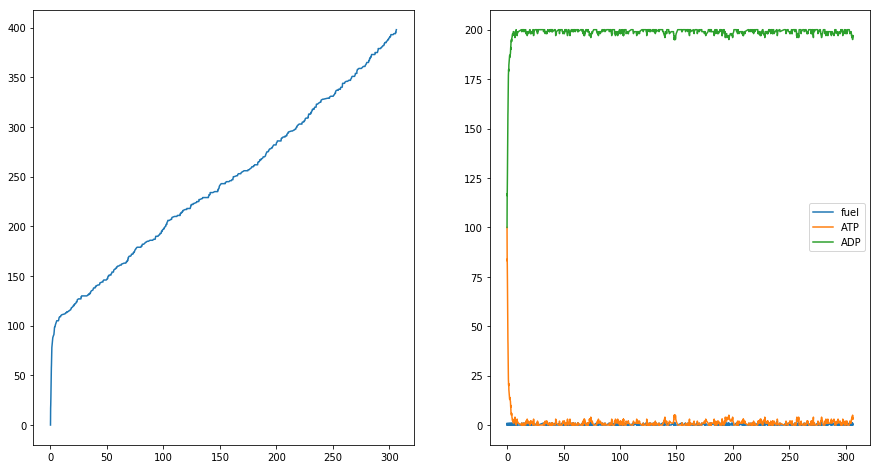

In [606]:
times, states = kmc(motor2(influx = 1, prod = .01, ΔF = 1, fd = .5), 1000, initial = (0, 100, 100, 100, 0))
fuel, atp, adp, p, m = zip(*states)
plt.subplot(121)
plt.plot(times, m)
plt.subplot(122)
plt.plot(times, fuel, label = 'fuel')
plt.plot(times, atp, label = 'ATP')
plt.plot(times, adp, label = 'ADP')
plt.legend()